# HW1

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torchvision import transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sklearn.decomposition

# Set random seed for reproducibility
manualSeed = 1337
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1337


In [2]:
data_root = './data'

workers = 1
ngpu = 1

image_size = 32
nc = 3

dataset_fraction = 0.1
batch_size = 64

use_normalization = False
use_pca = True
pca_components = 32

In [3]:
# Init data

if use_normalization:
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
else:
    transform = transforms.ToTensor()

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0)
                      else "mps:0" if torch.backends.mps.is_available() and ngpu > 0
else "cpu")


def get_subset(dataset, fraction):
    full_size = len(dataset)
    new_size = int(fraction * full_size)
    idxs = torch.randperm(full_size)[:new_size]
    return torch.utils.data.Subset(full_trainset, idxs)


full_trainset = dset.CIFAR10(root=data_root, train=True, download=True, transform=transform)
trainset = get_subset(full_trainset, dataset_fraction)

full_testset = dset.CIFAR10(root=data_root, train=False, download=True, transform=transform)
testset = get_subset(full_testset, dataset_fraction)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# PCA whitening if needed
if use_pca:
    dimension = image_size * image_size * nc
    trainset_flat = trainset.dataset.data[trainset.indices].reshape([-1, dimension])
    testset_flat = testset.dataset.data[testset.indices].reshape([-1, dimension])
    pca_model = sklearn.decomposition.PCA(n_components=pca_components, whiten=True)
    pca_trained = pca_model.fit(trainset_flat)
    trainset_flat = (trainset_flat - pca_trained.mean_) / np.sqrt(pca_trained.noise_variance_)
    testset_flat = (testset_flat - pca_trained.mean_) / np.sqrt(pca_trained.noise_variance_)
    train_targets = torch.tensor(trainset.dataset.targets)[trainset.indices]
    test_targets = torch.tensor(testset.dataset.targets)[testset.indices]
    trainset = torch.utils.data.TensorDataset(
        torch.tensor(trainset_flat.reshape([-1, image_size, image_size, nc]).transpose([0, 3, 1, 2])).float(),
        train_targets)
    testset = torch.utils.data.TensorDataset(
        torch.tensor(testset_flat.reshape([-1, image_size, image_size, nc]).transpose([0, 3, 1, 2])).float(),
        test_targets)


min = -4.855587005615234 max = 5.336846351623535


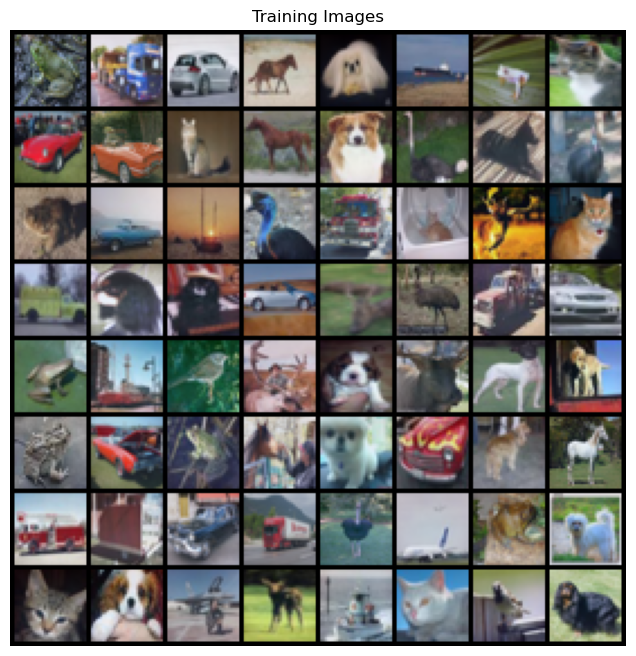

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=workers)

# Showing the data
real_batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64].cpu(), padding=2, normalize=True), (1, 2, 0)))
print(f'min = {torch.min(real_batch[0].to(device)).cpu()}', f'max = {torch.max(real_batch[0].to(device)).cpu()}')

In [6]:
# Model
class CnnClassifier(nn.Module):
    def __init__(self, ngpu, width=(64, 16), depth=2, residual=False):
        super().__init__()

        self.ngpu = ngpu
        self.depth = depth
        self.residual = residual
        self.conv_start = torch.nn.Sequential(
            nn.Conv2d(nc, width[0], 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # nn.Dropout(0.5),
        )
        self.conv_mid = torch.nn.Sequential(  # used only in the deeper versions
            nn.Conv2d(width[0], width[0], 3, padding=1),
        )
        self.conv_end = torch.nn.Sequential(
            nn.Conv2d(width[0], width[1], 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # nn.Dropout(0.5),
        )
        self.fc = torch.nn.Sequential(
            nn.Linear(width[1] * 8 * 8, 784),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(784, 10),
        )

    def forward(self, x):
        x = self.conv_start(x)
        for layer in range(2, self.depth):
            if self.residual:
                x = nn.functional.relu(self.conv_mid(x) + x)
            else:
                x = nn.functional.relu(self.conv_mid(x))
        x = self.conv_end(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class FcClassifier(nn.Module):
    def __init__(self, ngpu, width=256, depth=3):
        super().__init__()

        self.ngpu = ngpu
        self.width = width
        self.depth = depth

        self.fc = nn.Sequential(
            nn.Linear(nc * image_size * image_size, width),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
        )
        self.hidden = nn.Sequential(
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Sequential(
            nn.Linear(self.width, 10),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        for layer in range(2, self.depth):
            x = self.hidden(x)
        x = self.final(x)
        return x


In [7]:
# Parameters

sgd_lr = 0.01
# sgd_lrs = [0.01, 0.1, 1]
momentum = 0.9
# momentums = [0.09, 0.9, 0.99]
adam_lr = 1e-3
beta1 = 0.5
weight_decay = 0.001
std_dev = 0.001
# std_devs = [0.001]

use_adam = False
use_xavier = False
use_weight_decay = False
use_residual = False

losses_interval = 10
num_epochs = 50

In [8]:
# Training:
def train_model(model, optimizer, loss_criterion, verbose=False):
    training_losses = []
    training_losses_epochs = []
    test_losses = []
    loss_iters = 0
    last_iters = 0
    test_accuracies = []
    train_accuracies = []

    print("Starting Training Loop...")
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct_class = 0
        total_labels = 0
        for i, data in enumerate(trainloader):
            inputs, labels = [d.to(device) for d in data]
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            total_labels += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_class += (predicted == labels).sum().item()

            if i % losses_interval == losses_interval - 1:
                mean_loss = running_loss / losses_interval
                if verbose:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {mean_loss:.3f}')
                training_losses.append(mean_loss)
                running_loss = 0.0
                loss_iters += 1

        training_losses_epochs.append(np.mean(training_losses[last_iters:loss_iters]))
        train_accuracy = correct_class / total_labels
        train_accuracies.append(train_accuracy)
        last_iters = loss_iters

        model.eval()
        correct_class = 0
        total_labels = 0
        total_loss = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = [d.to(device) for d in data]
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                total_loss += loss.item() * len(data)  # doing weighted average over batches
                _, predicted = torch.max(outputs.data, 1)
                total_labels += labels.size(0)
                correct_class += (predicted == labels).sum().item()
        test_loss = total_loss / len(testloader)
        test_losses.append(test_loss)
        test_accuracy = correct_class / total_labels
        test_accuracies.append(test_accuracy)

        if verbose:
            print(f"[{epoch + 1}/{num_epochs}]\tTest Loss:\t{training_losses_epochs[-1]:.4f}")
            print(f"[{epoch + 1}/{num_epochs}]\tTrain Loss:\t{test_loss:.4f}")
            print(f"[{epoch + 1}/{num_epochs}]\tTrain accuracy:\t{train_accuracy * 100:.1f}%")
            print(f"[{epoch + 1}/{num_epochs}]\tTest accuracy:\t{test_accuracy * 100:.1f}%")

    return training_losses_epochs, test_losses, train_accuracies, test_accuracies

In [9]:

depths = [3, 4, 10]
width_pairs = [(64, 16), (256, 64), (512, 256)]
full_train_losses_epochs = []
full_test_losses = []
full_train_accuracies = []
full_test_accuracies = []


# for std_dev in std_devs:
#     for momentum in momentums:
#         for sgd_lr in sgd_lrs:
# for width_pair in width_pairs:
# for depth in depths:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        if use_xavier:
            nn.init.xavier_uniform(m.weight)
        else:
            nn.init.normal_(m.weight, std=std_dev)


# model = CnnClassifier(ngpu, residual=use_residual).to(device)
model = FcClassifier(ngpu).to(device)
loss_criterion = nn.CrossEntropyLoss()
model.apply(init_weights)
if use_adam:
    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)
else:
    if use_weight_decay:
        optimizer = torch.optim.SGD(model.parameters(), lr=sgd_lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=sgd_lr, momentum=momentum)
print("-------------------------------------------------------------------")
print(f"std_dev = {std_dev},\tmomentum = {momentum},\tsgd_lr = {sgd_lr}")
cur_train_losses_epochs, cur_test_losses, cur_train_accuracies, cur_test_accuracies = train_model(model, optimizer,
                                                                                                  loss_criterion,
                                                                                                  verbose=True)
full_train_losses_epochs.append(cur_train_losses_epochs)
full_test_losses.append(cur_test_losses)
full_train_accuracies.append(cur_train_accuracies)
full_test_accuracies.append(cur_test_accuracies)
print(f"Best train loss:\t{min(cur_train_losses_epochs):.3f}")
print(f"Best test loss:\t{min(cur_test_losses):.3f}")
print(f"Best train accuracy:\t{max(cur_train_accuracies) * 100:.1f}%")
print(f"Best test accuracy:\t{max(cur_test_accuracies) * 100:.1f}%")
print(f"Final train loss:\t{cur_train_losses_epochs[-1]:.3f}")
print(f"Final test loss:\t{cur_test_losses[-1]:.3f}")
print(f"Final train accuracy:\t{cur_train_accuracies[-1] * 100:.1f}%")
print(f"Final test accuracy:\t{cur_test_accuracies[-1] * 100:.1f}%")

-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.9,	sgd_lr = 0.01
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

[1,    10] loss: 2.301
[1,    20] loss: 2.301
[1,    30] loss: 2.305
[1,    40] loss: 2.302
[1,    50] loss: 2.305
[1,    60] loss: 2.303
[1,    70] loss: 2.303
[1/50]	Test Loss:	2.3031
[1/50]	Train Loss:	4.6085
[1/50]	Train accuracy:	10.0%
[1/50]	Test accuracy:	9.8%
[2,    10] loss: 2.303
[2,    20] loss: 2.305
[2,    30] loss: 2.301
[2,    40] loss: 2.299
[2,    50] loss: 2.304
[2,    60] loss: 2.303
[2,    70] loss: 2.300
[2/50]	Test Loss:	2.3019
[2/50]	Train Loss:	4.6086
[2/50]	Train accuracy:	10.4%
[2/50]	Test accuracy:	10.5%
[3,    10] loss: 2.298
[3,    20] loss: 2.304
[3,    30] loss: 2.292
[3,    40] loss: 2.284
[3,    50] loss: 2.246
[3,    60] loss: 2.209
[3,    70] loss: 2.147
[3/50]	Test Loss:	2.2543
[3/50]	Train Loss:	4.3554
[3/50]	Train accuracy:	15.6%
[3/50]	Test accuracy:	18.5%
[4,    10] loss: 2.184
[4,    20] loss: 2.129
[4,    30] loss: 2.101
[4,    40] loss: 2.126
[4,    50] loss: 2.073
[4,    60] loss: 2.092
[4,    70] loss: 2.090
[4/50]	Test Loss:	2.1135
[4/50]	T

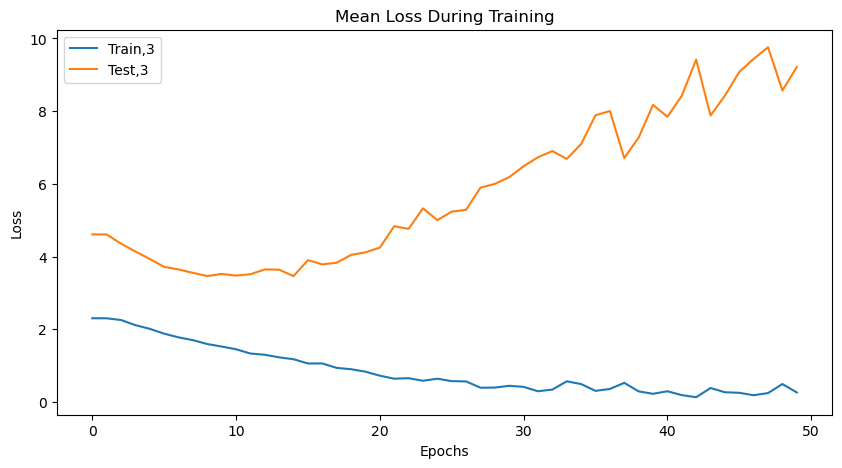

In [10]:
plt.figure(figsize=(10, 5))
for i in range(len(full_train_losses_epochs)):
    plt.plot(full_train_losses_epochs[i], label='Train,' + str(depths[i]))
    plt.plot(full_test_losses[i], label="Test," + str(depths[i]))
plt.title("Mean Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

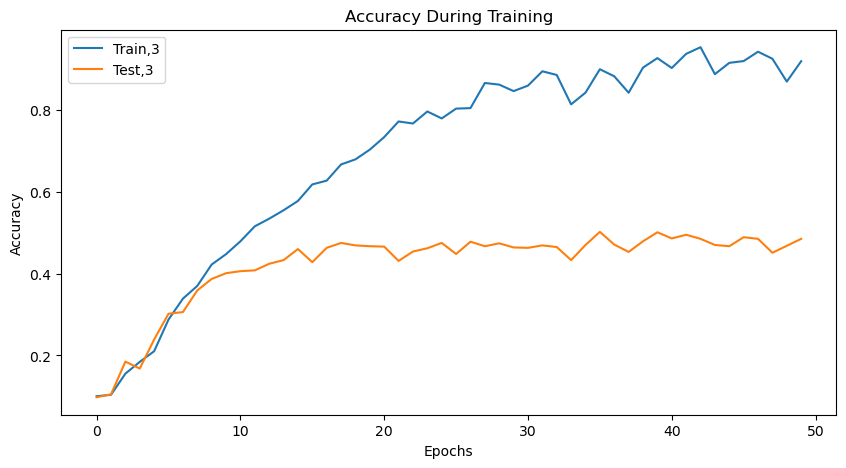

In [11]:
plt.figure(figsize=(10, 5))
for i in range(len(full_test_accuracies)):
    plt.plot(full_train_accuracies[i], label='Train,' + str(depths[i]))
    plt.plot(full_test_accuracies[i], label="Test," + str(depths[i]))
plt.title("Accuracy During Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()